In [5]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import heapq 
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import dateutil
import datetime 
import sys
import dask
sys.path.append("../")

from historical.readData.estimateData3 import read

from historical.readData.estimateData3 import read
from historical.readData.estimateData3 import search_travels
from historical.readData.estimateData3 import estimate
from historical.readData.estimateData3 import stops_distance

from historical.readData.travels3 import haversine2

def calcula_dist_shape(selec_linhas):
    distance_all_shapes = {}
    # print 'Calculando distancias dos shapes'
    '''calcula todas as distancias dos shapes'''
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"        
        
    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    
    for l, trip_id in enumerate(selec_linhas):

        trip = trips[trips.trip_id == trip_id]
        trip_shape = shapes[shapes['shape_id'].isin(trip['shape_id'])]
        shapelat = trip_shape.shape_pt_lat.tolist()
        shapelon = trip_shape.shape_pt_lon.tolist()

        # distancias dos shapes
        lon1 = shapelon[0]
        lat1 = shapelat[0]
        totalcal = [0.]
        dist = [0.]
        for lat2, lon2 in zip(shapelat[1:], shapelon[1:]):
            d = haversine2(lat1, lon1, lat2, lon2)
            d = d * 1000
            dist.append(d)
            totalcal.append(totalcal[-1] + d)
            lat1 = lat2
            lon1 = lon2
        distance_all_shapes[trip_id] = [shapelat, shapelon, totalcal]
    return distance_all_shapes

def stops_distance(linha):

    distances = calcula_dist_shape([linha])
    totalcal = distances[linha][2]
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"    

    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
    stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

    ida = trips[trips.trip_id == linha]
    shapeida = shapes[shapes['shape_id'].isin(ida['shape_id'])]
    idalat = shapeida.shape_pt_lat.tolist()
    idalon = shapeida.shape_pt_lon.tolist()
    total = shapeida.shape_dist_traveled.tolist()

    temp1 = stopid[stopid.trip_id == linha]
    stopsida = stops[stops['stop_id'].isin(temp1['stop_id'])]
    stopsida = stopsida.set_index('stop_id')
    stopsida = stopsida.reindex(index=temp1['stop_id'])

    stopslat = stopsida.stop_lat.tolist()
    stopslon = stopsida.stop_lon.tolist()

    dpontos = [None] * len(stopslat)
    index = 0
    lat = idalat
    lon = idalon
    total = 0
    p = ['depois'] * len(stopslat)
    for latb, lonb, i in zip(stopslat, stopslon, range(len(stopslat))):
        lat = lat[index:]
        lon = lon[index:]
        nn = haversine2(latb, lonb, np.array(lat), np.array(lon)) * 1000
        index = nn.argmin()
        total = total + index
        if index == 0:
            dpontos[i] = nn[index]
#            descontardist = nn[index]
        else:
            if totalcal[total] >= totalcal[total - 1] + nn[index - 1]:
                p[i] = 'antes'
            dpontos[i] = totalcal[total - 1] + nn[index - 1]

    mid_points = []
#    mid_points.append(200)
    p1 = dpontos[0]
    for p2 in dpontos[1:]:
        mid_points.append(p1 + (p2-p1)/2)
        p1 = p2
    dpontos = [i/1000. for i in dpontos]
    mid_points = [i/1000. for i in mid_points]
    # dpontos = [val-descontardist for val in dpontos]
    # stopsida.reset_index(drop=True, inplace=True)
    # stopsida['distancia'] = dpontos
    # stopsida.sort_values('distancia',axis=0,inplace=True)
    # stopsida.reset_index(drop=True, inplace=True)

    # gmap = gmplot.GoogleMapPlotter(idalat[0], idalon[0], 19)
    # gmap.marker(idalat[0],idalon[0], title='Test text')
    # gmap.plot(idalat, idalon, 'blue')
    # gmap.scatter(idalat, idalon, c='blue', size=10, marker=True, titles=totalcal)
    # gmap.scatter(stopsida['stop_lat'].tolist(), stopsida['stop_lon'].tolist(), c='red', size=10, marker=True,
    #             titles=["Ponto " + str(i + 1) + ": dist: " + str(stopsida['distancia'][i]) + ' ' + p[i] for i in
    #                     range(len(dpontos))])

    # gmap.draw('pontos.html')

    return dpontos, mid_points

def read(filedata,filerep):
    df0 = pd.read_pickle(filedata, compression=None)
    with open(filerep, 'rb') as handle:
        reps = pickle.load(handle, encoding='latin1')
    return df0, reps

In [6]:
# if __name__ == '__main__':

selected_line = ['8700-10-1']

# '8700-10-0',
# selected_line = ['8700-10-1',                
#                 '7545-10-1',
#                 '7545-10-0',
#                 '6450-10-1',
#                 '6450-10-0',
#                 '3301-10-1',
# #                 '3301-10-0',
#                 '2290-10-1',
#                 '2290-10-0',
# #                 '574J-10-1',
# #                 '574J-10-0',
# #                 '477P-10-1',
#                 '477P-10-0',
# #                 '351F-10-1',
# #                 '351F-10-0'
#                 ]

In [7]:
pth_files_GTFS = "../historical/readData/dados/gtfs/"

trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

periods = ['morning', 'm_peak', 'i_peak', 'a_peak', 'night']

line = selected_line[0]
pth_files_lines = "../historical/readData/"
p, mp = stops_distance(line)
df, reps = read(pth_files_lines + "trips_" + line + ".dsk", pth_files_lines + "interps_" + line + ".rep")   
df_temporal = df.loc[(df['day'] >=  np.datetime64('2017-09-01'))]

minutesRT = df_temporal['start'].astype(str).str.split(':', expand=True).astype(float)[0]*60 + \
                       df_temporal['start'].astype(str).str.split(':', expand=True).astype(float)[1] + \
                       df_temporal['start'].astype(str).str.split(':', expand=True).astype(float)[2]/60 +\
                       df_temporal['time']

df_temporal['exact_time'] = np.array(df_temporal['day'], dtype='datetime64[s]') + \
                                           pd.to_timedelta(minutesRT, unit='m')

/home/marcos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Temporal correlation of links during 24 hours with a historical dataset of 12 working days
==========

/home/marcos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: bias and ddof have no effect and are deprecated
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


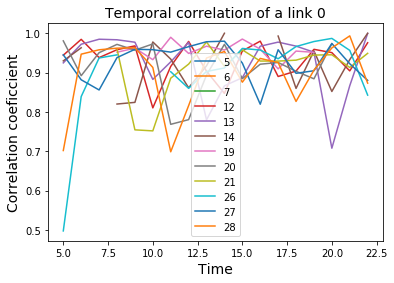

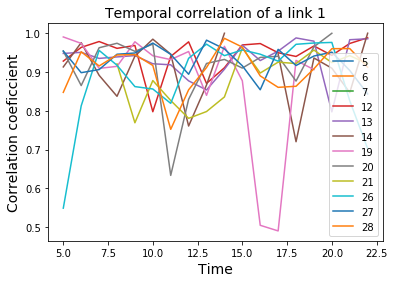

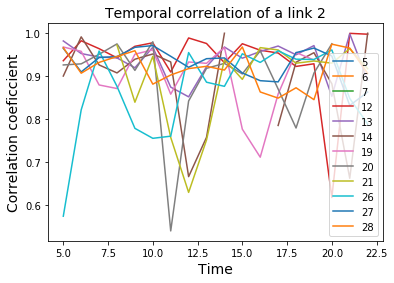

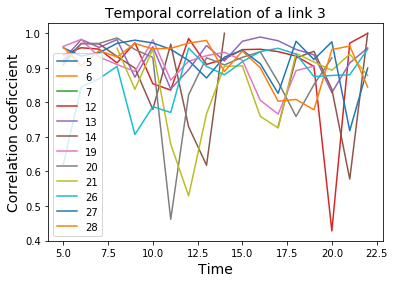

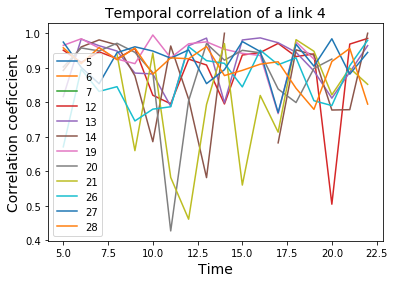

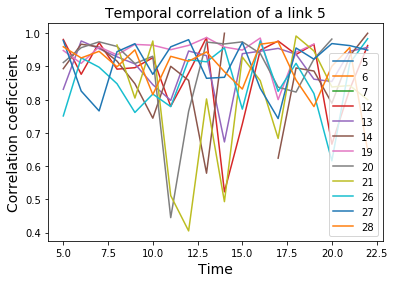

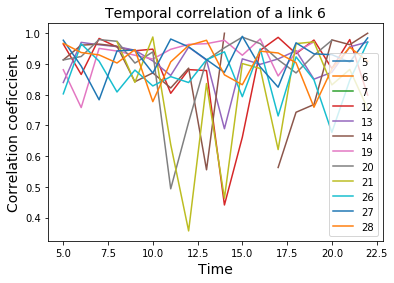

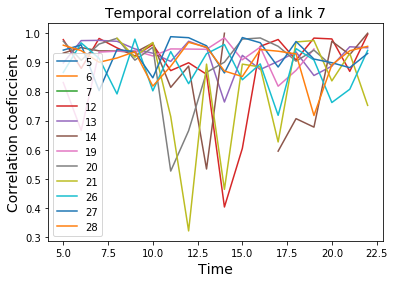

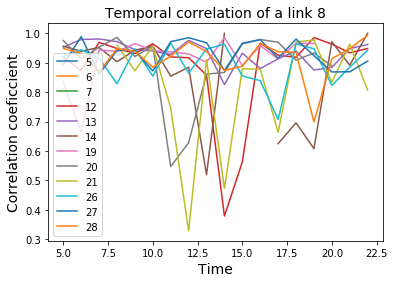

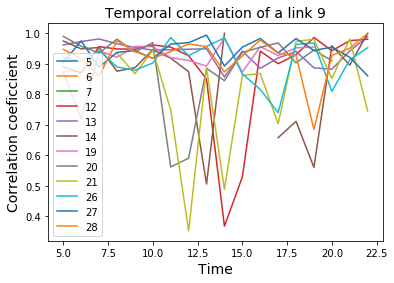

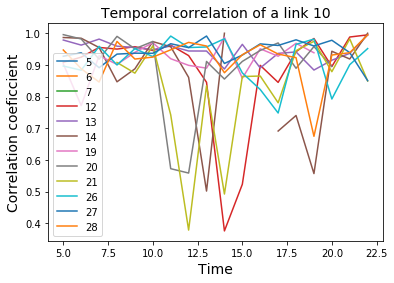

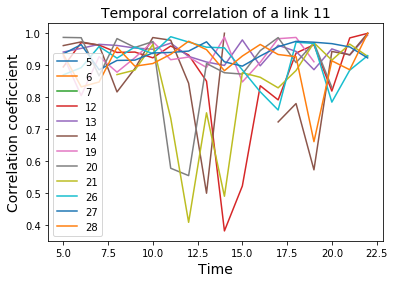

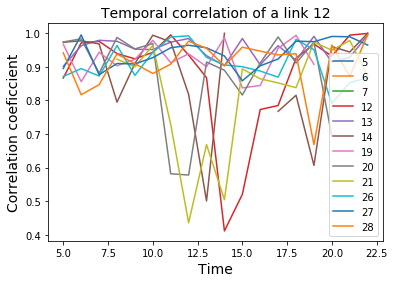

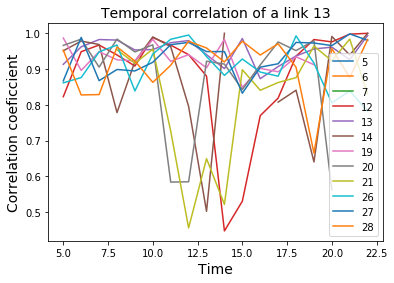

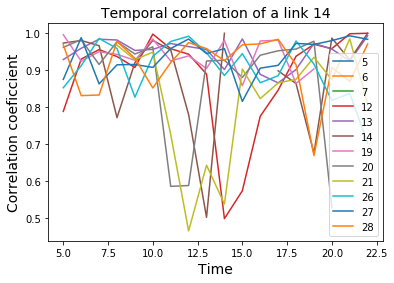

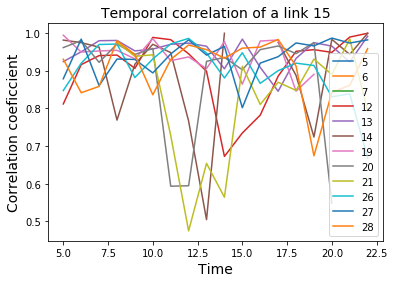

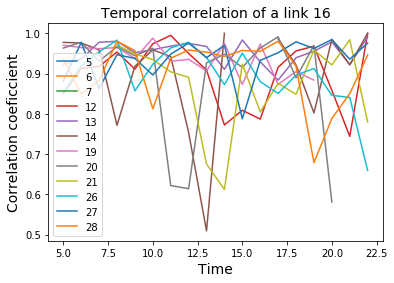

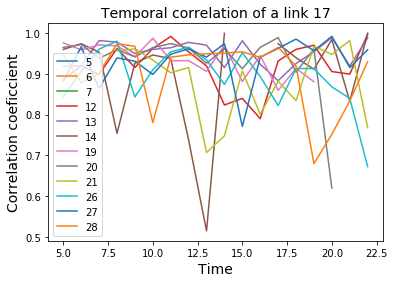

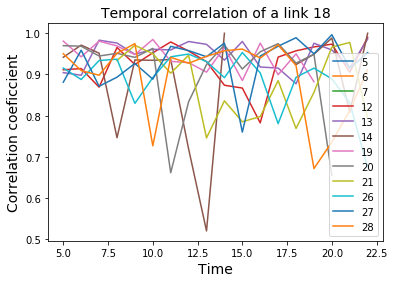

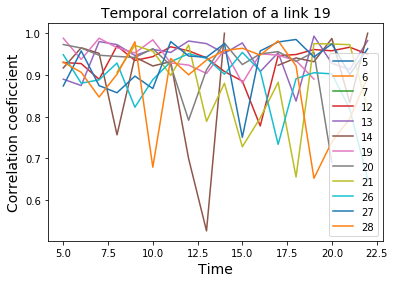

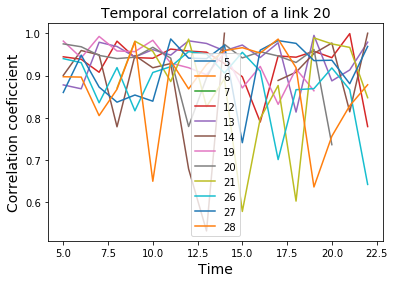

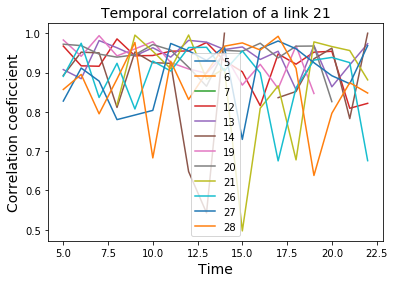

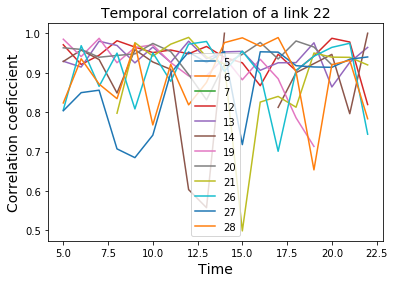

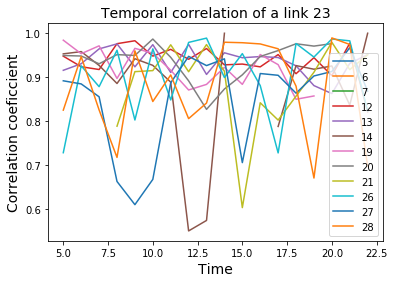

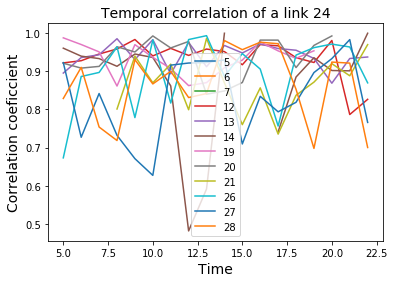

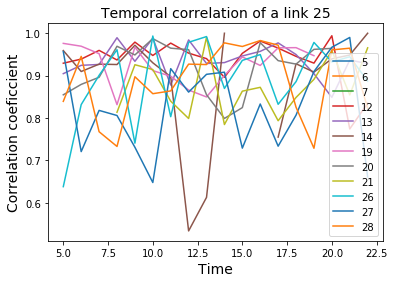

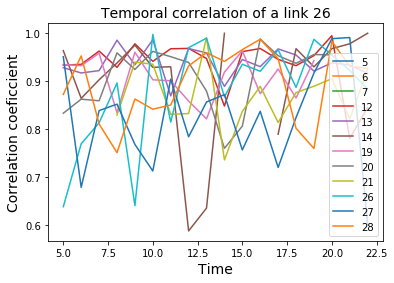

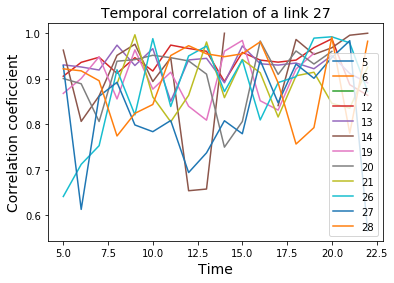

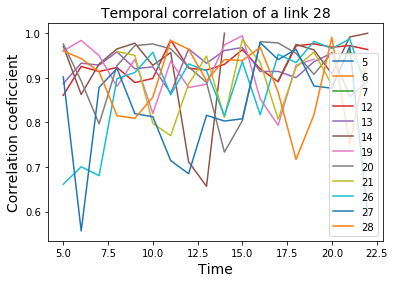

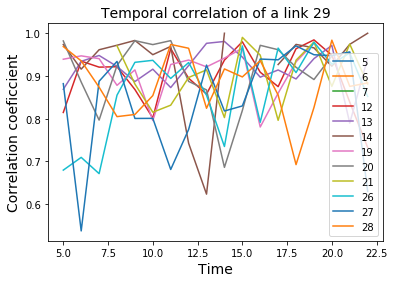

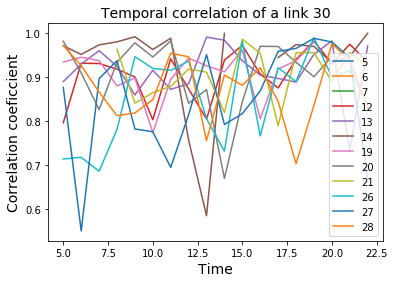

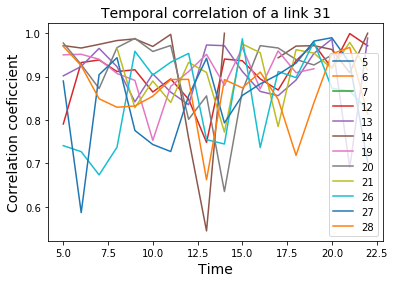

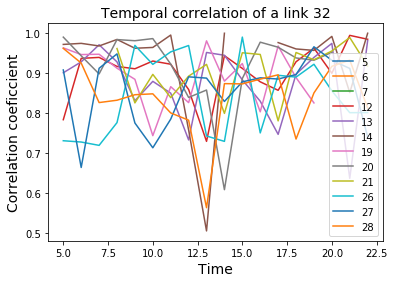

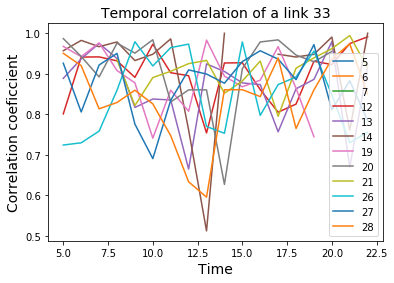

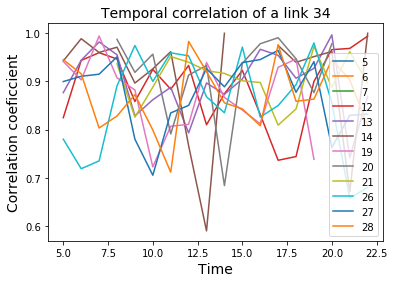

In [107]:
for link_line in range(0, 35):
    days = [5, 6, 7, 12, 13, 14, 19, 20, 21, 26, 27, 28]
    fig, (ax0) = plt.subplots(nrows=1, sharex=True)
    for day_period in days:
        selected_day = np.datetime64('2017-09-' + (('0' + str(day_period)) if day_period < 10 else  str(day_period)))
        day_temp  = df_temporal.loc[(df_temporal['day'] ==  selected_day)] 


        cor_link = []
        for period_hour in range(0, 23):
            request_travels_1 = day_temp.loc[(day_temp['exact_time'] >= str(selected_day) + ' ' + str(period) + ':00:00') & 
                      (day_temp['exact_time'] >= str(selected_day) + ' ' + str(period) + ':59:00')]

            request_travels_2 = day_temp.loc[(day_temp['exact_time'] >= str(selected_day) + ' ' + str(period + 1) + ':00:00') & 
                      (day_temp['exact_time'] >= str(selected_day) + ' ' + str(period + 1) + ':59:00')]

            travels = sorted(list(set(request_travels_1['numtravel'])))
            est_mp = estimate(mp, reps, travels)

            link_df = []
            link_df_later = []
            for tr in travels:
                tempo = [a[0] if a.size>0 else np.nan for a in est_mp[tr]]
                row = [tuple([tempo[i+1]-pos for i, pos in enumerate(tempo[:-1])])]
                d = pd.DataFrame(row, columns=range(len(mp)-1))
                link_df.append(float(d[link_line]))                
                
            
            travels = sorted(list(set(request_travels_2['numtravel'])))
            est_mp = estimate(mp, reps, travels)

            link_df_later = []
            for tr in travels:
                tempo = [a[0] if a.size>0 else np.nan for a in est_mp[tr]]
                row = [tuple([tempo[i+1]-pos for i, pos in enumerate(tempo[:-1])])]
                d = pd.DataFrame(row, columns=range(len(mp)-1))
                link_df_later.append(float(d[link_line]))                
            
            cor_link.append(np.corrcoef(np.sort(link_df)[0:min(len(link_df), len(link_df_later))],
                           np.sort(link_df_later)[0:min(len(link_df), len(link_df_later))], bias=True)[0][1])
            
        plt.plot(cor_link)
    plt.title('Temporal correlation of a link ' + str(link_line),fontsize=14)
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('Correlation coeficcient',fontsize=14)
    plt.legend(days)
    plt.show()


Spatial correlation of links during 24 hours with a historical dataset of 12 working days
=======

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


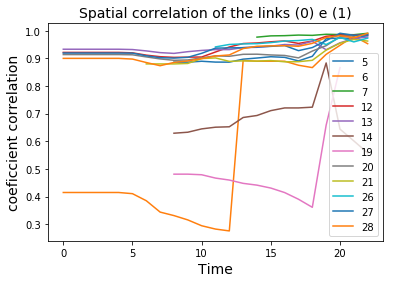

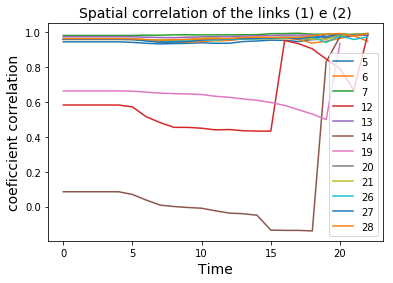

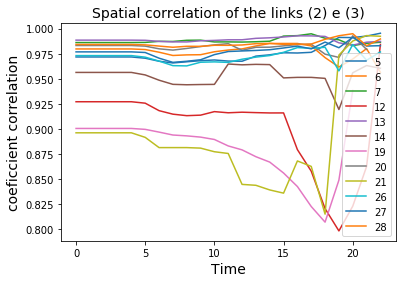

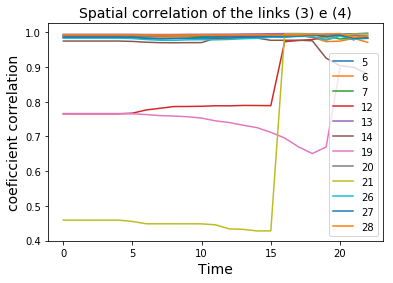

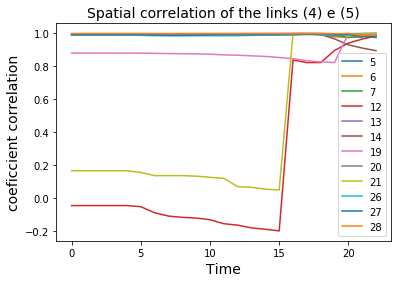

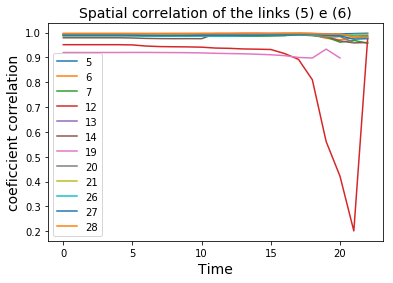

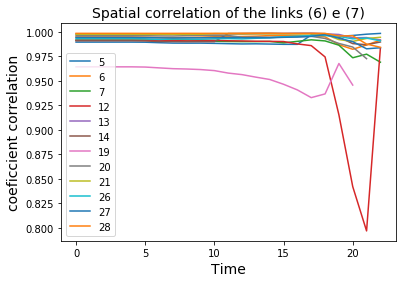

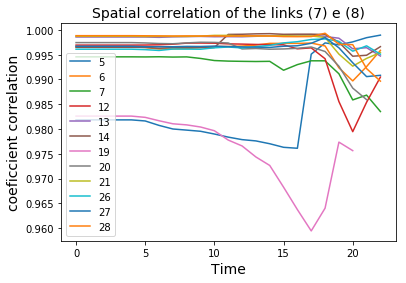

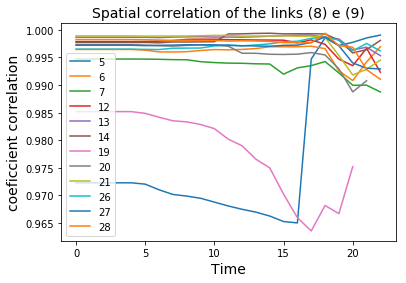

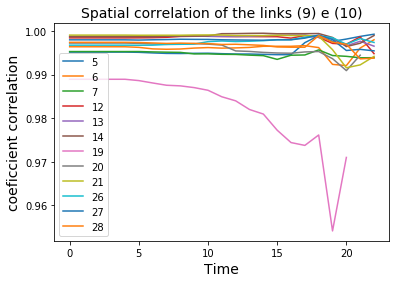

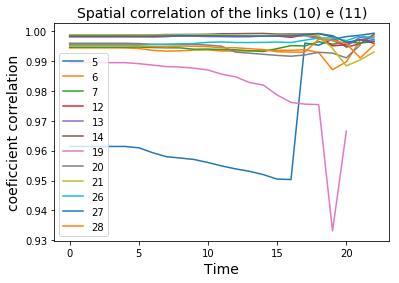

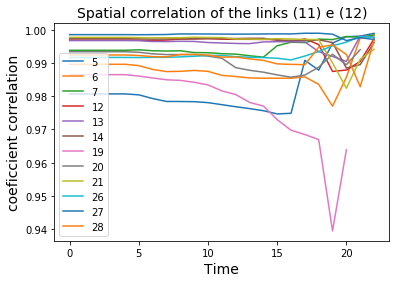

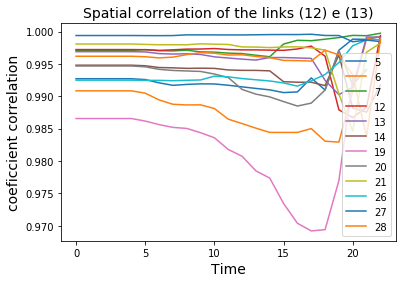

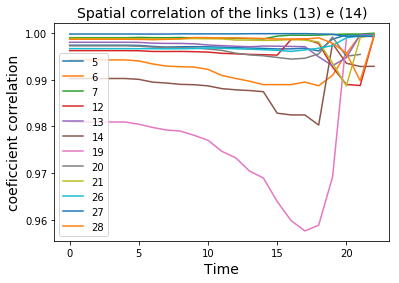

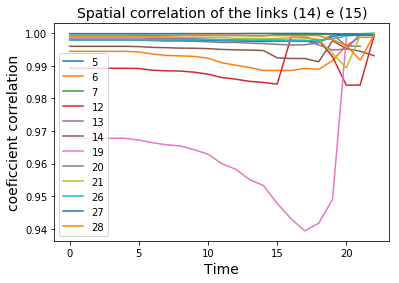

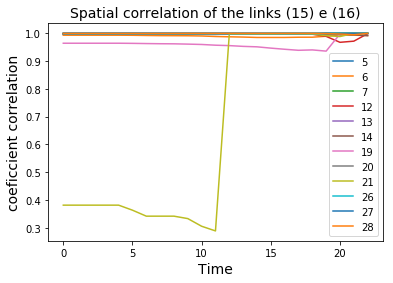

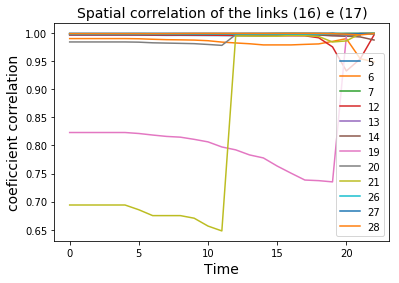

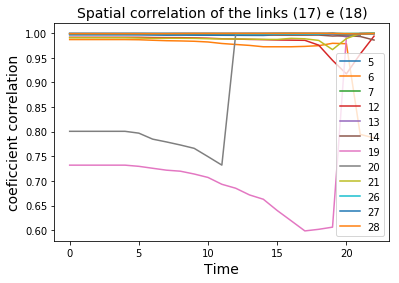

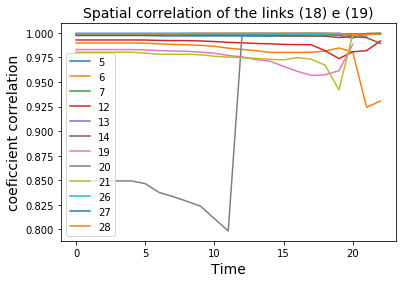

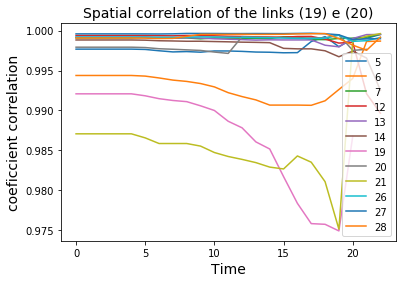

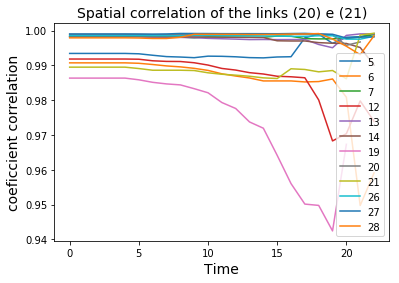

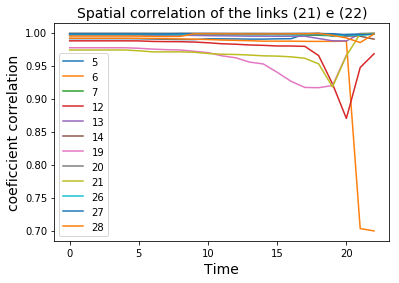

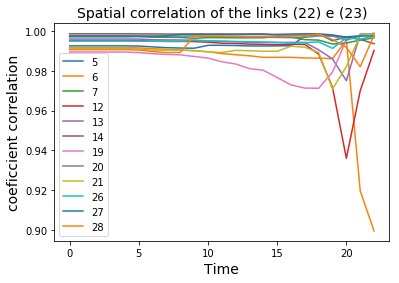

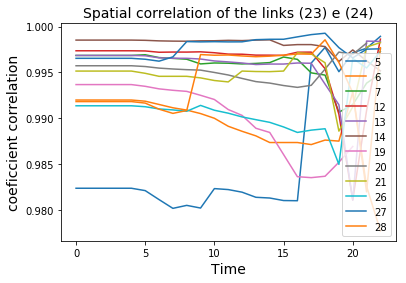

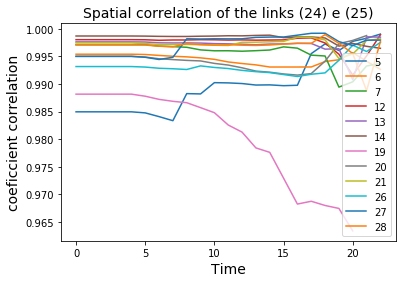

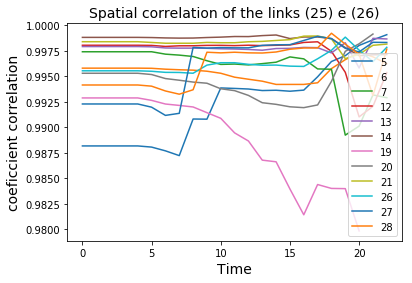

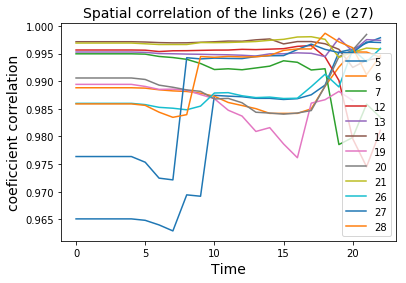

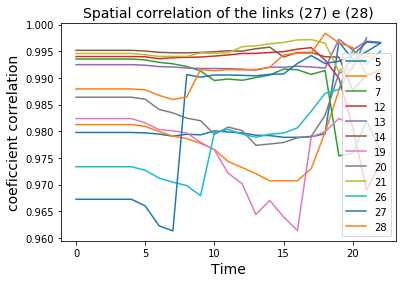

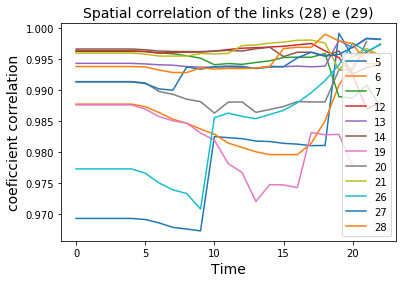

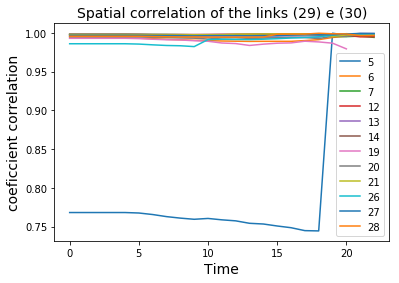

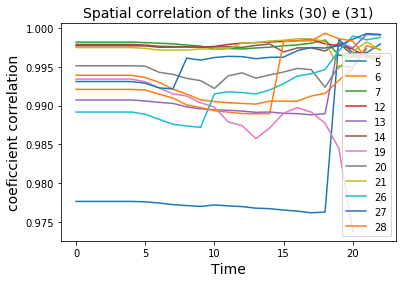

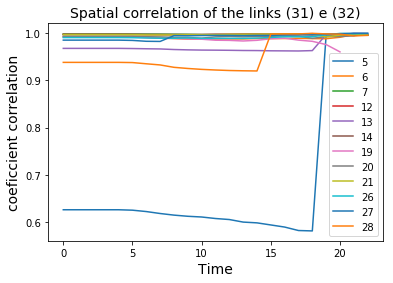

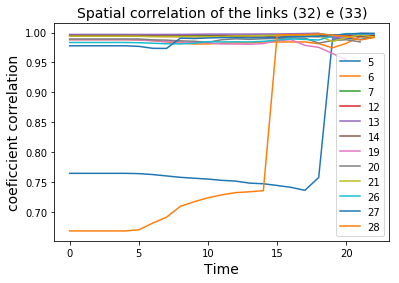

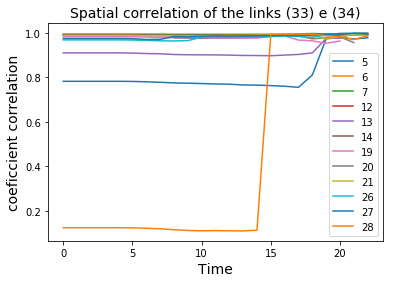

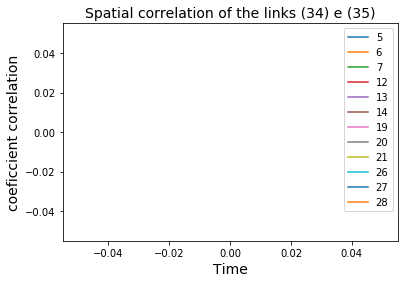

In [9]:
for link_line in range(0, 35):
    days = [5, 6, 7, 12, 13, 14, 19, 20, 21, 26, 27, 28]
#     fig, (ax0) = plt.subplots(nrows=1, sharex=True)
    for day_period in days:
        selected_day = np.datetime64('2017-09-' + (('0' + str(day_period)) if day_period < 10 else  str(day_period)))
        day_temp  = df_temporal.loc[(df_temporal['day'] ==  selected_day)] 

        
        cor_link = []
        for period in range(0, 23):
            request_travels = day_temp.loc[(day_temp['exact_time'] >= str(selected_day) + ' ' + str(period) + ':00:00') & 
                      (day_temp['exact_time'] >= str(selected_day) + ' ' + str(period) + ':59:00')]

            travels = sorted(list(set(request_travels['numtravel'])))
            est_mp = estimate(mp, reps, travels)

            link_df = []
            link_df_after = []
            for tr in travels:
                tempo = [a[0] if a.size>0 else np.nan for a in est_mp[tr]]
                row = [tuple([tempo[i+1]-pos for i, pos in enumerate(tempo[:-1])])]
                d = pd.DataFrame(row, columns=range(len(mp)-1))
                link_df.append(float(d[link_line][0]))
                link_df_after.append(float(d[link_line +1][0]))      
            
            cor_link.append(np.corrcoef(link_df, link_df_after)[0][1])
#             print(link_df, link_df_after)
            
        plt.plot(cor_link)
    plt.title('Spatial correlation of the links (' + str(link_line) + ') e (' + str(link_line + 1) + ')' ,fontsize=14)
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('coeficcient correlation',fontsize=14)
    plt.legend(days)
    plt.show()
